# Testing Methods of Data Imputation
### Andy Nguyen, Michael Wolfe, Joseph Caguioa
### 7/14/20

## Objective

Often times when gathering data sources for model building, data scientists will find their data is incomplete or missing values. This can come in the form of uncategorized samples or blank metrics. These missing values present a number of unique challenges; primarily, interpreting the missing values as a signal or imputing/ignoring them.

There are a few recognized patterns of missing values. The two main categories are missing at random and missing not at random. Missing at random values, as the name implies, are values that are missing completely randomly. There's usually no discernable pattern to why they are missing, although sometimes there are values missing given the value of another variable (though there is no pattern within the missing variable itself). The other type, missing not at random, occurs when there is a discernable pattern within the variable for missing values. An example is that a variable may be missing if it is lower than a particular values.

Imputing is the processing of filling in missing values with a type of placeholder or default value. This is necessary for some types of models, such as linear regression, that require normalized or complete variables to generate a proper model. Imputation carries inherent risk, namely towards biasing the model if a large number of values are defaulted or imputed.

As such, it is important for data scientists to examine variables they want to impute to determine the best strategy, and test the effects of imputation on a varying range of missing values. It may be necessary to create a complex imputation method to counteract biasing effects.

In this study, we will test the effects of imputation on the Boston Housing dataset. We will impute on the AGE column for 3 different scenarios: missing at random, missing at random given another variable, and missing not at random. We will establish a linear regression model as a baseline, and test all 3 scenarios with a range of missing percentages, then compare the results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ml_metrics import rmse
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

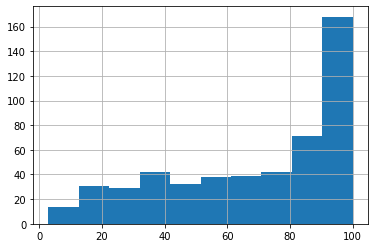

In [2]:
boston = load_boston()
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['MEDV'] = boston.target
bos.describe
bos['AGE'].hist()

The Age values show significant right skew. Given this information the mean is not a reliable imputation method - we will use the median instead.

## Fit a linear regressor to the data as a baseline.  

In [3]:
train_set = bos.sample(frac=0.7, random_state=100)
test_set = bos[~bos.isin(train_set)].dropna()

In [4]:
X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

In [5]:
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)
print(reg.intercept_)
print(reg.get_params())

0.7478284701218886
[-1.35456753e-01  5.48606010e-02  5.46611167e-02  3.57648807e+00
 -2.01163242e+01  3.96567027e+00  1.33685712e-02 -1.48716658e+00
  2.99295349e-01 -9.83868843e-03 -9.45023886e-01  6.45207267e-03
 -5.77572297e-01]
36.079347688282304
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}


What is the loss and what are the goodness of fit parameters?

In [6]:
print("The loss of the model is {}.".format(reg.score(X_train, Y_train)))

The loss of the model is 0.7478284701218886.


In [7]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%orig_mae)
print("MSE:  %.3f"%orig_mse)
print("RMSE:  %.3f"%orig_rmse_val)
print("R2:  %.3f"%orig_r2)

MAE: 3.605
MSE:  24.099
RMSE:  4.909
R2:  0.705


In [8]:
res_frame = pd.DataFrame({'data':'original',
                   'imputation':'none',
                   'mae': orig_mae, 
                   'mse': orig_mse, 
                   'rmse':orig_rmse_val, 
                   'R2':orig_r2,
                   'mae_diff':np.nan,
                   'mse_diff':np.nan,
                   'rmse_diff':np.nan,
                   'R2_diff':np.nan}, index=[0])
res_frame

,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.70494,NaN,NaN,NaN,NaN


In [9]:
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)

Step 2: Select 1%, 5% 10%, 20%, 33%, and 50% of your data in a single column [hold that column selection constant throughout all iterations] (Completely at random), replace the original value with a NaN (i.e., “not a number” – ex., np.nan) and then perform an imputation for the missing values.   

In [10]:
in_sample = bos.sample(frac=0.01, random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

In [11]:
train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

In [12]:
X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

In [13]:
reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

0.7477990218800383
[-1.35495603e-01  5.46769124e-02  5.59365305e-02  3.58336026e+00
 -2.00572242e+01  3.97115055e+00  1.28757977e-02 -1.48614678e+00
  2.99858619e-01 -9.89226289e-03 -9.44220284e-01  6.46707615e-03
 -5.76184693e-01]
36.00239693382231
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


In [14]:
Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

MAE: 3.610
MSE:  24.097
RMSE:  4.909
R2:  0.705


In [15]:
temp_frame = pd.DataFrame({'data':'1% imputed',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

In [16]:
res_frame = pd.concat([res_frame, temp_frame])
res_frame

,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015


In [17]:
in_sample = bos.sample(frac=0.05, random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'5% imputed',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7474054150918357
[-1.35479447e-01  5.39751912e-02  5.68455747e-02  3.64818312e+00
 -1.95450772e+01  4.02186229e+00  5.81560155e-03 -1.51361766e+00
  2.97374435e-01 -9.83852440e-03 -9.37852993e-01  6.56772095e-03
 -5.66318324e-01]
35.7129847852341
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.603
MSE:  23.959
RMSE:  4.895
R2:  0.707


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707


In [18]:
in_sample = bos.sample(frac=0.1, random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'10% imputed',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7475901636386664
[-1.35704898e-01  5.42248059e-02  5.65665563e-02  3.61841897e+00
 -1.98062823e+01  3.99558651e+00  9.59472574e-03 -1.50029324e+00
  2.99036913e-01 -9.87201825e-03 -9.42429391e-01  6.52870503e-03
 -5.70192288e-01]
35.85538686739871
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.607
MSE:  24.040
RMSE:  4.903
R2:  0.706


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718


In [19]:
in_sample = bos.sample(frac=0.2, random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'20% imputed',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7475244246396398
[-1.35668627e-01  5.42339417e-02  5.75158074e-02  3.64277357e+00
 -1.97135946e+01  4.00820309e+00  8.16071048e-03 -1.51158118e+00
  2.98373506e-01 -9.89070337e-03 -9.40085350e-01  6.52989253e-03
 -5.67554567e-01]
35.783642651728854
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.613
MSE:  24.018
RMSE:  4.901
R2:  0.706


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990


In [20]:
in_sample = bos.sample(frac=0.33, random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'33% imputed',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7475049506773191
[-1.35315559e-01  5.33919444e-02  5.89311604e-02  3.64446061e+00
 -1.96292875e+01  4.02686961e+00  7.67041127e-03 -1.50620066e+00
  2.98345141e-01 -9.83261044e-03 -9.44144893e-01  6.53803679e-03
 -5.65129040e-01]
35.6265936313266
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.616
MSE:  24.027
RMSE:  4.902
R2:  0.706


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990
0,33% imputed,AGE,3.616309,24.027006,4.901735,0.705815,0.011738,-0.071499,-0.007288,0.000875


In [21]:
in_sample = bos.sample(frac=0.5, random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'50% imputed',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7473373503518663
[-1.35809798e-01  5.31403869e-02  5.70717678e-02  3.68536976e+00
 -1.90691241e+01  4.07694384e+00 -3.45722949e-03 -1.54799454e+00
  2.94339306e-01 -9.76870569e-03 -9.31654051e-01  6.61033432e-03
 -5.57201038e-01]
35.65787483295208
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.601
MSE:  23.889
RMSE:  4.888
R2:  0.708


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990
0,33% imputed,AGE,3.616309,24.027006,4.901735,0.705815,0.011738,-0.071499,-0.007288,0.000875
0,50% imputed,AGE,3.601175,23.888715,4.887608,0.707508,-0.003396,-0.209790,-0.021414,0.002569


Step 3: Take two columns and create data “Missing at Random” when controlled for a third variable (i.e., if Variable Z is > 30, then Variables X, Y are randomly missing).  Use your preferred imputation method to fill in 10%, 20% and 30% of your missing data.

Our sampling rule will be based on the TAX variable. We will be looking at any case where TAX is less than 300, and will use that as a sampling rule to remove and impute values.

In [22]:
sample_rule = bos[bos['TAX']>300]
in_sample = sample_rule.sample(n=round(len(bos)*0.1), random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()

in_sample['DIS'] = np.nan
in_sample['RAD'] = np.nan
in_sample['DIS'] = in_sample['DIS'].fillna(out_sample['DIS'].median())
in_sample['RAD'] = in_sample['RAD'].fillna(out_sample['RAD'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'10% imputed, random conditional',
                   'imputation':'DIS, RAD',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7207321707972568
[-8.54051643e-02  2.28874529e-02  2.14959020e-02  3.95018785e+00
 -1.40946388e+01  4.56807844e+00  1.98952584e-02 -9.07840801e-01
  1.58091317e-02  3.34866266e-03 -9.00356272e-01  6.06041343e-03
 -5.63978435e-01]
23.29140085984583
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.693
MSE:  26.055
RMSE:  5.104
R2:  0.681


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990
0,33% imputed,AGE,3.616309,24.027006,4.901735,0.705815,0.011738,-0.071499,-0.007288,0.000875
0,50% imputed,AGE,3.601175,23.888715,4.887608,0.707508,-0.003396,-0.209790,-0.021414,0.002569
0,"10% imputed, random conditional","DIS, RAD",3.692728,26.055483,5.104457,0.680979,0.088156,1.956979,0.195434,-0.023961


In [23]:
sample_rule = bos[bos['TAX']>300]
in_sample = sample_rule.sample(n=round(len(bos)*0.2), random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()

in_sample['DIS'] = np.nan
in_sample['RAD'] = np.nan
in_sample['DIS'] = in_sample['DIS'].fillna(out_sample['DIS'].median())
in_sample['RAD'] = in_sample['RAD'].fillna(out_sample['RAD'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'20% imputed, random conditional',
                   'imputation':'DIS, RAD',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7166581456971772
[-7.59962264e-02  1.87088414e-02  3.31163503e-02  3.93842441e+00
 -1.25588157e+01  4.59373049e+00  2.53448973e-02 -7.41018866e-01
 -1.56756034e-03  3.97887222e-03 -9.06129398e-01  5.80835280e-03
 -5.76587846e-01]
21.425812416795814
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.734
MSE:  26.589
RMSE:  5.156
R2:  0.674


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990
0,33% imputed,AGE,3.616309,24.027006,4.901735,0.705815,0.011738,-0.071499,-0.007288,0.000875
0,50% imputed,AGE,3.601175,23.888715,4.887608,0.707508,-0.003396,-0.209790,-0.021414,0.002569
0,"10% imputed, random conditional","DIS, RAD",3.692728,26.055483,5.104457,0.680979,0.088156,1.956979,0.195434,-0.023961
0,"20% imputed, random conditional","DIS, RAD",3.733552,26.589079,5.156460,0.674445,0.128981,2.490574,0.247437,-0.030494


In [24]:
sample_rule = bos[bos['TAX']>300]
in_sample = sample_rule.sample(n=round(len(bos)*0.3), random_state=99)
out_sample = bos[~bos.isin(in_sample)].dropna()

in_sample['DIS'] = np.nan
in_sample['RAD'] = np.nan
in_sample['DIS'] = in_sample['DIS'].fillna(out_sample['DIS'].median())
in_sample['RAD'] = in_sample['RAD'].fillna(out_sample['RAD'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'30% imputed, random conditional',
                   'imputation':'DIS, RAD',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.7133781947898175
[-6.48649826e-02  1.41020882e-02  3.26953250e-02  4.05097349e+00
 -1.16308679e+01  4.64098975e+00  2.82978881e-02 -5.92572594e-01
 -8.04266284e-02  5.99956146e-03 -8.95646564e-01  4.99989123e-03
 -5.76483394e-01]
19.73538808683767
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.743
MSE:  27.010
RMSE:  5.197
R2:  0.669


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990
0,33% imputed,AGE,3.616309,24.027006,4.901735,0.705815,0.011738,-0.071499,-0.007288,0.000875
0,50% imputed,AGE,3.601175,23.888715,4.887608,0.707508,-0.003396,-0.209790,-0.021414,0.002569
0,"10% imputed, random conditional","DIS, RAD",3.692728,26.055483,5.104457,0.680979,0.088156,1.956979,0.195434,-0.023961
0,"20% imputed, random conditional","DIS, RAD",3.733552,26.589079,5.156460,0.674445,0.128981,2.490574,0.247437,-0.030494
0,"30% imputed, random conditional","DIS, RAD",3.743284,27.010335,5.197147,0.669288,0.138713,2.911830,0.288124,-0.035652


Step 4:  Create a “Missing Not at Random” pattern in which 25% of the data is missing for a single column.

For this step our pattern will be based on quantiles: we will remove any value in the 25th percentile of the AGE variable.

In [25]:
bos.quantile(.25)

CRIM         0.082045
ZN           0.000000
INDUS        5.190000
CHAS         0.000000
NOX          0.449000
RM           5.885500
AGE         45.025000
DIS          2.100175
RAD          4.000000
TAX        279.000000
PTRATIO     17.400000
B          375.377500
LSTAT        6.950000
MEDV        17.025000
Name: 0.25, dtype: float64

In [26]:
in_sample = bos.loc[bos['AGE']<=45.025]
out_sample = bos[~bos.isin(in_sample)].dropna()
in_sample['AGE'] = np.nan
in_sample['AGE'] = in_sample['AGE'].fillna(out_sample['AGE'].median())
imputed_data = pd.concat([in_sample, out_sample])
imputed_data = imputed_data.sort_index()

train_set = imputed_data.iloc[train_index]
test_set = imputed_data.iloc[test_index]

X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values

reg2 = LinearRegression().fit(X_train, Y_train)
print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = rmse(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)

temp_frame = pd.DataFrame({'data':'25% Missing Not At Random',
                   'imputation':'AGE',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

res_frame = pd.concat([res_frame, temp_frame])
res_frame

0.74882024305077
[-1.38722412e-01  4.72664711e-02  4.92364341e-02  3.68307222e+00
 -2.01437938e+01  4.03157690e+00  2.88202631e-02 -1.49849855e+00
  3.10319982e-01 -1.04093423e-02 -9.40174703e-01  6.46378582e-03
 -5.69186977e-01]
34.31942340549029
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.582
MSE:  23.733
RMSE:  4.872
R2:  0.709


,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.604571,24.098505,4.909023,0.704940,NaN,NaN,NaN,NaN
0,1% imputed,AGE,3.610206,24.097314,4.908902,0.704954,0.005634,-0.001191,-0.000121,0.000015
0,5% imputed,AGE,3.602697,23.959056,4.894799,0.706647,-0.001874,-0.139449,-0.014224,0.001707
0,10% imputed,AGE,3.606641,24.039858,4.903046,0.705658,0.002070,-0.058647,-0.005977,0.000718
0,20% imputed,AGE,3.613030,24.017633,4.900779,0.705930,0.008459,-0.080872,-0.008244,0.000990
0,33% imputed,AGE,3.616309,24.027006,4.901735,0.705815,0.011738,-0.071499,-0.007288,0.000875
0,50% imputed,AGE,3.601175,23.888715,4.887608,0.707508,-0.003396,-0.209790,-0.021414,0.002569
0,"10% imputed, random conditional","DIS, RAD",3.692728,26.055483,5.104457,0.680979,0.088156,1.956979,0.195434,-0.023961
0,"20% imputed, random conditional","DIS, RAD",3.733552,26.589079,5.156460,0.674445,0.128981,2.490574,0.247437,-0.030494
0,"30% imputed, random conditional","DIS, RAD",3.743284,27.010335,5.197147,0.669288,0.138713,2.911830,0.288124,-0.035652


## Results

Now that all our tests are complete, we will compare the results by plotting the goodness of fit parameters and comparing the outcomes of each imputation scenario.

In [27]:
res_frame['data']

0                           original
0                         1% imputed
0                         5% imputed
0                        10% imputed
0                        20% imputed
0                        33% imputed
0                        50% imputed
0    10% imputed, random conditional
0    20% imputed, random conditional
0    30% imputed, random conditional
0          25% Missing Not At Random
Name: data, dtype: object

Text(0.5, 0, 'Mean Absolute Error (MAE)')

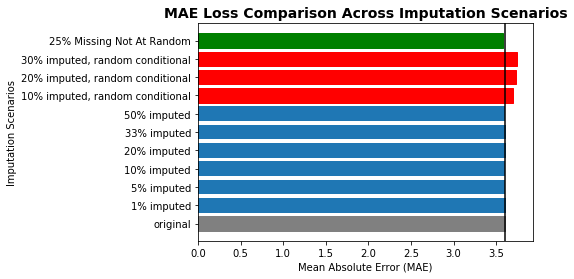

In [28]:
fig, ax = plt.subplots()
mae = ax.barh(np.arange(len(res_frame['data'])), res_frame['mae'])
ax.set_yticks(np.arange(len(res_frame['data'])))
ax.set_yticklabels(res_frame['data'])
#res_frame.plot.barh(x="data", y="mae", legend=None)
plt.axvline(x=3.604571, color='black')
# set color of baseline bar to gray
mae[0].set_color('gray')
# single variable at random imputation scenario set to blue
# set color of conditional at random imputation scenario bars of 2 variables to red
for i in range(7,10):
    mae[i].set_color('red')
# set color of non missing at random imputation scenario bars to green
mae[10].set_color('green')
plt.title("MAE Loss Comparison Across Imputation Scenarios", fontsize=14, fontweight='bold')
plt.ylabel("Imputation Scenarios")
plt.xlabel("Mean Absolute Error (MAE)")

Text(0.5, 0, 'Mean Squared Error (MSE)')

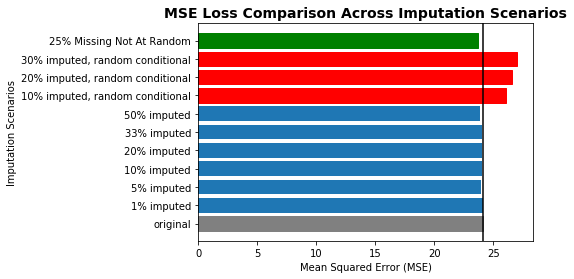

In [32]:
fig, ax = plt.subplots()
mae = ax.barh(np.arange(len(res_frame['data'])), res_frame['mse'])
ax.set_yticks(np.arange(len(res_frame['data'])))
ax.set_yticklabels(res_frame['data'])
plt.axvline(x=24.098505, color='black')
# set color of baseline bar to gray
mae[0].set_color('gray')
# single variable at random imputation scenario set to blue
# set color of conditional at random imputation scenario bars of 2 variables to red
for i in range(7,10):
    mae[i].set_color('red')
# set color of non missing at random imputation scenario bars to green
mae[10].set_color('green')
plt.title("MSE Loss Comparison Across Imputation Scenarios", fontsize=14, fontweight='bold')
plt.ylabel("Imputation Scenarios")
plt.xlabel("Mean Squared Error (MSE)")

Text(0.5, 0, 'Root Mean Squared Error (RMSE)')

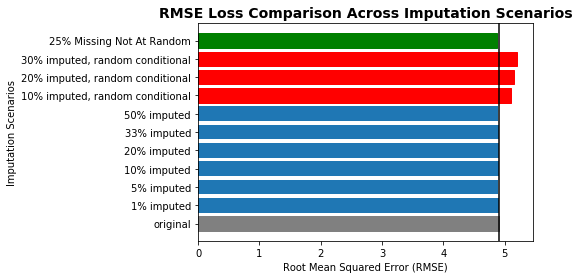

In [33]:
fig, ax = plt.subplots()
mae = ax.barh(np.arange(len(res_frame['data'])), res_frame['rmse'])
ax.set_yticks(np.arange(len(res_frame['data'])))
ax.set_yticklabels(res_frame['data'])
plt.axvline(x=4.909023, color='black')
# set color of baseline bar to gray
mae[0].set_color('gray')
# single variable at random imputation scenario set to blue
# set color of conditional at random imputation scenario bars of 2 variables to red
for i in range(7,10):
    mae[i].set_color('red')
# set color of non missing at random imputation scenario bars to green
mae[10].set_color('green')
plt.title("RMSE Loss Comparison Across Imputation Scenarios", fontsize=14, fontweight='bold')
plt.ylabel("Imputation Scenarios")
plt.xlabel("Root Mean Squared Error (RMSE)")

Text(0.5, 0, 'R-Squared')

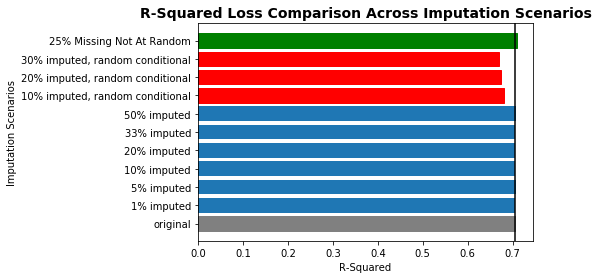

In [34]:
fig, ax = plt.subplots()
mae = ax.barh(np.arange(len(res_frame['data'])), res_frame['R2'])
ax.set_yticks(np.arange(len(res_frame['data'])))
ax.set_yticklabels(res_frame['data'])
plt.axvline(x=0.704940, color='black')
# set color of baseline bar to gray
mae[0].set_color('gray')
# single variable at random imputation scenario set to blue
# set color of conditional at random imputation scenario bars of 2 variables to red
for i in range(7,10):
    mae[i].set_color('red')
# set color of non missing at random imputation scenario bars to green
mae[10].set_color('green')
plt.title("R-Squared Loss Comparison Across Imputation Scenarios", fontsize=14, fontweight='bold')
plt.ylabel("Imputation Scenarios")
plt.xlabel("R-Squared")

## Summary

For each of the missing values we selected AGE as our target column for missing values. In every example we used the median age to impute, given the strong right skew in the histogram. We saw varying results from the baseline in each scenario, but mostly the error rate was not too far off. Generally the error decreased with the exception of random conditional.

In the random imputation the MSE did not change much except at the highest levels (30-50%). This is likely due to the AGE variable normalizing overall at these higher levels. This is a promising result, as this means at certain levels of missing values that we can impute on these variables without impacting the behavior of the model too much.

Interestingly, the random conditional imputation had the worst performance, increasing the MSE at each level. This could be due to how AGE is distributed at those particular TAX levels (and therefore skewing the AGE with our imputation method) but without more in-depth analysis it is not clear.

The greatest improvement in MSE appeared in the 25% not missing at random schema. This is likely due to how we removed the data: since we removed the 25% quartile of the values, we naturally skewed the age further to the right. Since our median remained the same, this likely normalized the variable and made the model more resilient. However, it is unclear if this is actually more "accurate" since the age would not be reflective of reality in this case.

All in all it appears our chosen method of imputation has the least impact on the model in a random scenario, especially when fewer values are missing. A good follow-up would be a deep dive on more complex scenarios, especially AGE values missing at certain TAX levels. This imputation scheme could benefit from ANOVA or some other variance analysis to determine the appropriate distribution at these variable levels.